This work was done by Loris Dugay and Nicolas Guerin

The dataset was taken from Kaggle : https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -uq "/content/drive/MyDrive/chest_xray.zip" -d "/content/drive/MyDrive/ressource"

In [ ]:
# Import libraries

import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import cv2
import glob
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

In [ ]:
# Create a function to parse pneumonia and normal images in each numpy array
# I just set the size of the images to 180 and convert the images to grayscale for better running time calculation

labels = ['PNEUMONIA', 'NORMAL']
img_size = 180
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
# Use the get_data function to create three numpy array who contain all our data

train = get_data('/content/drive/MyDrive/ressource/chest_xray/train')
test = get_data('/content/drive/MyDrive/ressource/chest_xray/test')
val = get_data('/content/drive/MyDrive/ressource/chest_xray/val')

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



Pneumonia: 3875
Normal: 1341
Difference between Pneumonia and Normal cases : 2534


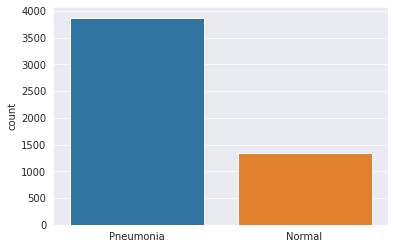

In [ ]:
# Watch data distribution with seaborn

list_cases = []
pneumonia = 0 
normal = 0 

for i in train:
    if(i[1] == 0):
        list_cases.append("Pneumonia")
        pneumonia += 1
    else:
        list_cases.append("Normal")
        normal += 1
sns.set_style('darkgrid')
sns.countplot(x=list_cases)
     
print('Pneumonia:', pneumonia)
print('Normal:', normal)
print('Difference between Pneumonia and Normal cases :', pneumonia-normal)

We can see that we have too many case of pneumonia in comparison of normal case, it can cause a future overfiting problem, to solve this we will use data aumentation.

In [ ]:
# Just to be sure we verify the shape of our data

train.shape

(5216, 2)

Text(0.5, 1.0, 'NORMAL')

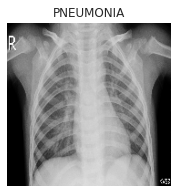

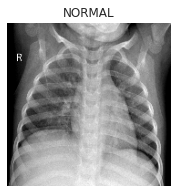

In [ ]:
# Print two differents cases

plt.figure(figsize = (3,3))
plt.imshow(train[2][0], cmap='gray')
plt.axis('off')
plt.title(labels[train[2][1]])

plt.figure(figsize = (3,3))
plt.imshow(train[-2][0], cmap='gray')
plt.axis('off')
plt.title(labels[train[-2][1]])

*With my lack of experience in medical domain, the only thing I can see is that image with pneumonia are more gray than normal image*

In [ ]:
# Create list train test and validation for our future CNN model

X_train = []
y_train = []

X_test = []
y_test = []

X_val = []
y_val = []

for feature, label in train:
    X_train.append(feature)
    y_train.append(label)

for feature, label in test:
    X_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    X_val.append(feature)
    y_val.append(label)

In [ ]:
# Normalize the data for a better score in our CNN

X_train = np.array(X_train) / 255
X_test = np.array(X_test) / 255
X_val = np.array(X_val) / 255

# Resize data shape for deep learning 

X_train = X_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

X_test = X_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

X_val = X_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [ ]:
# Use datagen to generate batches of tensor image data with real-time data augmentation
# This is a good solution when we have a unbalanced dataset like this one

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    vertical_flip = True,
    horizontal_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range = 0.2
)

In [ ]:
# Fit our training dataset with our datagen solution

datagen.fit(X_train)

In [ ]:
# Check the shape of all data which contains our images

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(5216, 180, 180, 1)
(624, 180, 180, 1)
(16, 180, 180, 1)


In [ ]:
# Check the shape of all data which contains our labels

print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(5216,)
(624,)
(16,)


In [ ]:
# Create our Convolution neural network
cnn = Sequential()

# First convolution
cnn.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (180,180,1)))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

# Second convolution
cnn.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

# Third convolution
cnn.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

# Fourth convolution
cnn.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

# Fifth convolution
cnn.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D((2,2) , strides = 2 , padding = 'same'))

# Convert the squared stored images to a one dimensional tensor 
cnn.add(Flatten())

# Dense layer which is just a regular densely-connected neural network layer
cnn.add(Dense(units = 128 , activation = 'relu'))

# Use Dropout to avoid overfitting
cnn.add(Dropout(0.2))

# Dense layer matching the 2 values of the labels (we count the 0)
cnn.add(Dense(units = 1 , activation = 'sigmoid'))

In [ ]:
# View model summary

cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 180, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 90, 90, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        3

In [ ]:
# Create the network

adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

cnn.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Create a learning rate reduction when the training is not progressing

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
# Fit the CNN model, with only 10 epoch

history = cnn.fit(datagen.flow(X_train,y_train, batch_size=10), validation_data=(X_val, y_val), epochs = 10, callbacks=learning_rate_reduction)

Epoch 1/10
522/522 [==============================] - 437s 835ms/step - loss: 0.4213 - accuracy: 0.8363 - val_loss: 4.8747 - val_accuracy: 0.5000
Epoch 2/10
522/522 [==============================] - 437s 837ms/step - loss: 0.2254 - accuracy: 0.9025 - val_loss: 1.6079 - val_accuracy: 0.5000
Epoch 3/10
522/522 [==============================] - 451s 865ms/step - loss: 0.2077 - accuracy: 0.9102 - val_loss: 0.8413 - val_accuracy: 0.6875
Epoch 4/10
522/522 [==============================] - 449s 860ms/step - loss: 0.1944 - accuracy: 0.9222 - val_loss: 1.1276 - val_accuracy: 0.5000
Epoch 5/10
522/522 [==============================] - 439s 842ms/step - loss: 0.1755 - accuracy: 0.9338 - val_loss: 1.3322 - val_accuracy: 0.5000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
Epoch 6/10
522/522 [==============================] - 441s 844ms/step - loss: 0.1702 - accuracy: 0.9318 - val_loss: 0.5015 - val_accuracy: 0.7500
Epoch 7/10
522/522 [======================

In [ ]:
# Evaluate the model with X_Test

cnn.evaluate(X_test, y_test)

20/20 [==============================] - 13s 616ms/step - loss: 0.3315 - accuracy: 0.9022


[0.3315034806728363, 0.9022436141967773]

In [ ]:
# Do some predictions

predictions = cnn.predict_classes(X_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:20]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

# Print the classification report

print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.89      0.96      0.92       390
   Normal (Class 1)       0.93      0.80      0.86       234

           accuracy                           0.90       624
          macro avg       0.91      0.88      0.89       624
       weighted avg       0.90      0.90      0.90       624



In [ ]:
# Create a confusion matrix 

confusion = confusion_matrix(y_true=y_test, y_pred=predictions)
confusion

array([[376,  14],
       [ 47, 187]])

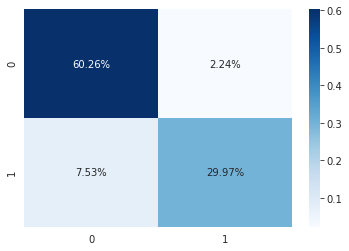

In [ ]:
# Print our confusion matrix with seaborn and use percentage instead of classic values (already printed in the last code cell)

sns.heatmap(confusion/np.sum(confusion), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
# Take data from the 375 position of predictions to have pneumonia and normal cases

cases_predictions = predictions[375:624]

In [ ]:
# Take data from the 375 position of y_test to have both pneumonia and normal cases

true_test = y_test[375:624]

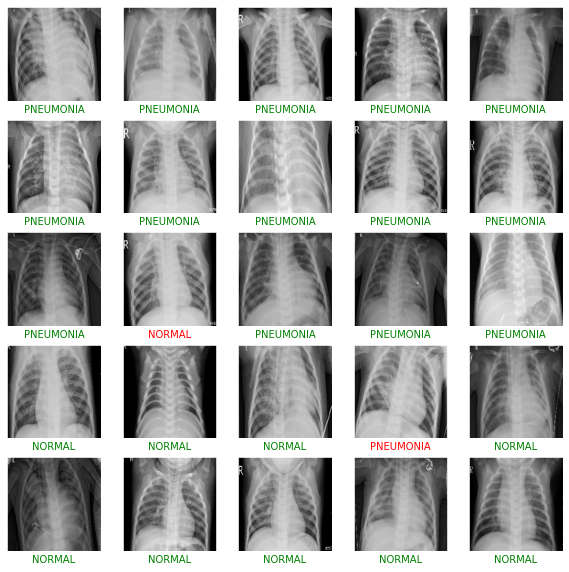

In [ ]:
# Plot the data in green if they are a valid prediction or in red if they are not

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train.reshape(-1, img_size, img_size)[i], cmap='gray')
    if(cases_predictions[i]==true_test[i]):
        plt.xlabel(labels[cases_predictions[i]], color='green')
    else:
        plt.xlabel(labels[cases_predictions[i]], color='red')
plt.show()